In [ ]:
# =====================================================
# MODEL PREPROCESSING
# =====================================================
import pandas as pd
import numpy as np

TRAIN_PATH = "/kaggle/input/cdc-dataset/train(1).xlsx"
TEST_PATH  = "/kaggle/input/cdc-test/test2.xlsx"
#Reading train and test files
train_df = pd.read_excel(TRAIN_PATH)
test_df  = pd.read_excel(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

TARGET_COL = "price"
SPATIAL_COLS = ["lat", "long"]

TABULAR_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_living15",
    "sqft_lot15"
]
#Basic Checks
required_train_cols = TABULAR_FEATURES + SPATIAL_COLS + [TARGET_COL]
required_test_cols  = TABULAR_FEATURES + SPATIAL_COLS

missing_train = set(required_train_cols) - set(train_df.columns)
missing_test  = set(required_test_cols)  - set(test_df.columns)

if missing_train:
    raise ValueError(f"Missing columns in TRAIN dataset: {missing_train}")

if missing_test:
    raise ValueError(f"Missing columns in TEST dataset: {missing_test}")

print("All required columns are present.")

# Cleaning of dataset 
train_df = train_df.dropna(subset=[TARGET_COL]).reset_index(drop=True)
num_cols = train_df[TABULAR_FEATURES + SPATIAL_COLS].columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())
test_df[num_cols]  = test_df[num_cols].fillna(train_df[num_cols].median())

print("\nTarget (price) summary:")
print(train_df[TARGET_COL].describe())

print("\nLatitude range :", train_df["lat"].min(), "→", train_df["lat"].max())
print("Longitude range:", train_df["long"].min(), "→", train_df["long"].max())

print("\nFinal train shape:", train_df.shape)
print("Final test shape :", test_df.shape)



Train shape: (16209, 21)
Test shape : (5404, 20)
All required columns are present.

Target (price) summary:
count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

Latitude range : 47.1593 → 47.7776
Longitude range: -122.519 → -121.315

Final train shape: (16209, 21)
Final test shape : (5404, 20)


In [ ]:
# =====================================================
# DATA_FETCHER.py
# =====================================================
import os
import math
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# =====================================================
# OUTPUT DIRECTORIES (I am working on kaggle)
# =====================================================
TRAIN_IMG_DIR = "/kaggle/working/images/train"
TEST_IMG_DIR  = "/kaggle/working/images/test"

os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)

# ======================================================
# ESRI WORLD IMAGERY ENDPOINT
# ======================================================
ESRI_URL = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export"

# ======================================================
# IMAGE PARAMETERS
# ======================================================
IMG_SIZE = 256          # Output image size: 256x256
AREA_METERS = 200       # Area around property (200m x 200m)

# ======================================================
# BASIC GEO HELPERS
# ======================================================
def meters_to_lat(meters):
    return meters / 111320

def meters_to_lon(meters, lat):
    return meters / (111320 * math.cos(math.radians(lat)))

def get_bbox(lat, lon, meters):
    dlat = meters_to_lat(meters)
    dlon = meters_to_lon(meters, lat)
    return (
        lon - dlon / 2,
        lat - dlat / 2,
        lon + dlon / 2,
        lat + dlat / 2
    )

# ======================================================
# IMAGE FETCH FUNCTION (Without keeping any delay)
# ======================================================
def fetch_esri_image(lat, lon, save_path, retries=3):
    bbox = get_bbox(lat, lon, AREA_METERS)

    params = {
        "bbox": ",".join(map(str, bbox)),
        "bboxSR": 4326,
        "imageSR": 4326,
        "size": f"{IMG_SIZE},{IMG_SIZE}",
        "format": "png",
        "f": "image"
    }

    for _ in range(retries):
        try:
            response = requests.get(
                ESRI_URL,
                params=params,
                timeout=20
            )

            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert("RGB")
                img.save(save_path)
                return True

        except requests.exceptions.ReadTimeout:
            continue
        except Exception:
            continue

    return False

# ======================================================
# DOWNLOAD TRAIN IMAGES
# ======================================================
print("Downloading TRAIN satellite images...")

train_success = 0
train_fail = 0

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = f"{TRAIN_IMG_DIR}/{idx}.png"

    if os.path.exists(img_path):
        continue

    if fetch_esri_image(row["lat"], row["long"], img_path):
        train_success += 1
    else:
        train_fail += 1

print(f"TRAIN images downloaded: {train_success}")
print(f"TRAIN images failed    : {train_fail}")

# ======================================================
# DOWNLOAD TEST IMAGES
# ======================================================
print("Downloading TEST satellite images...")

test_success = 0
test_fail = 0

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_path = f"{TEST_IMG_DIR}/{idx}.png"

    if os.path.exists(img_path):
        continue

    if fetch_esri_image(row["lat"], row["long"], img_path):
        test_success += 1
    else:
        test_fail += 1

print(f"TEST images downloaded: {test_success}")
print(f"TEST images failed    : {test_fail}")

print("Satellite image acquisition completed.")


100%|██████████| 16209/16209 [2:30:47<00:00,  1.79it/s]  


TRAIN images downloaded: 16209
TRAIN images failed    : 0


100%|██████████| 5404/5404 [54:28<00:00,  1.65it/s]  

TEST images downloaded: 5404
TEST images failed    : 0
Satellite image acquisition completed.


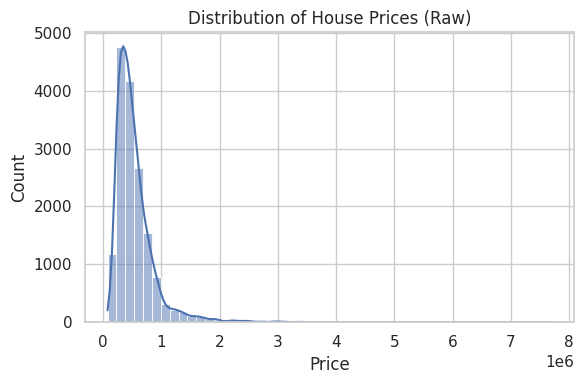

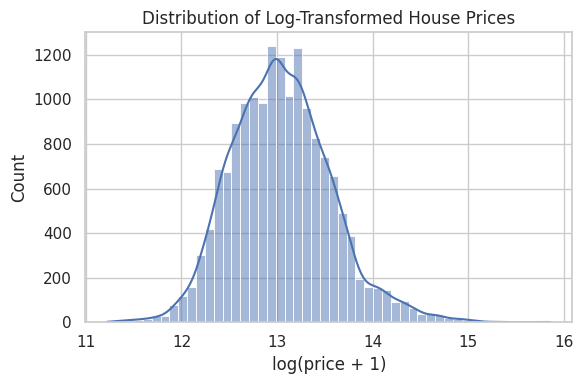

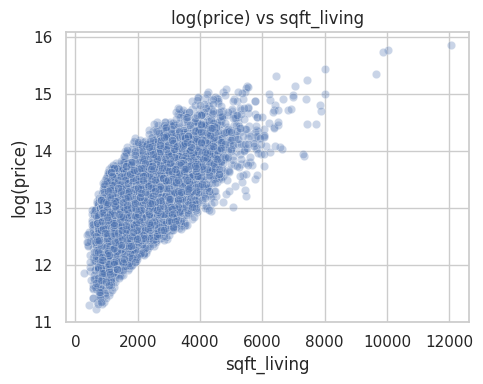

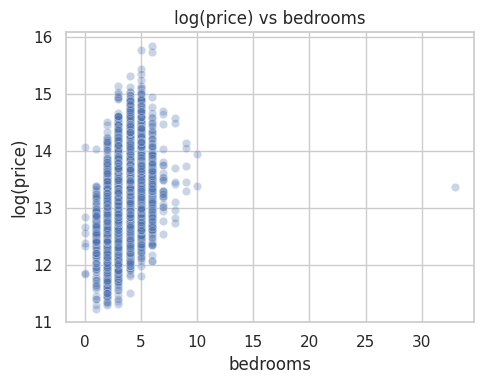

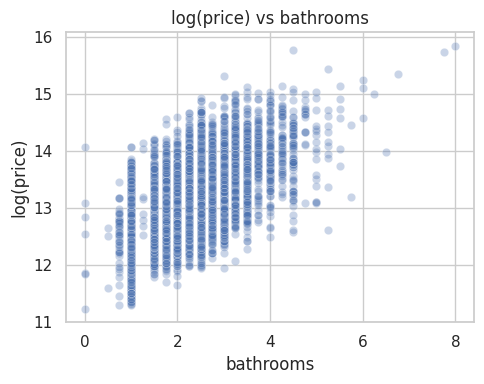

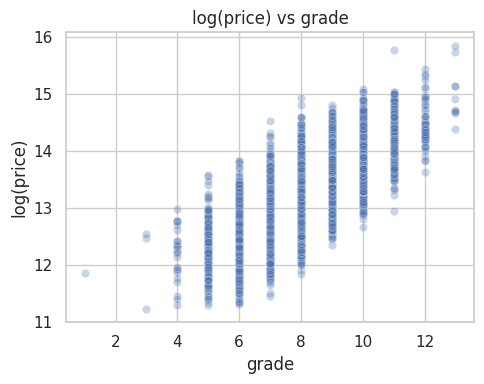

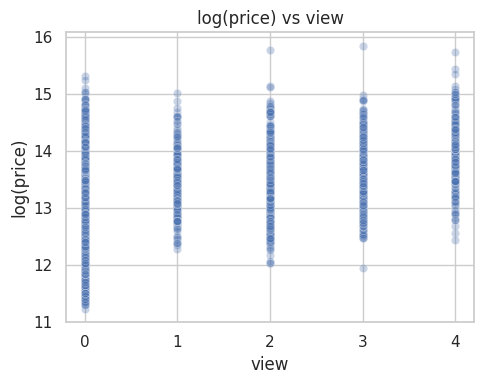

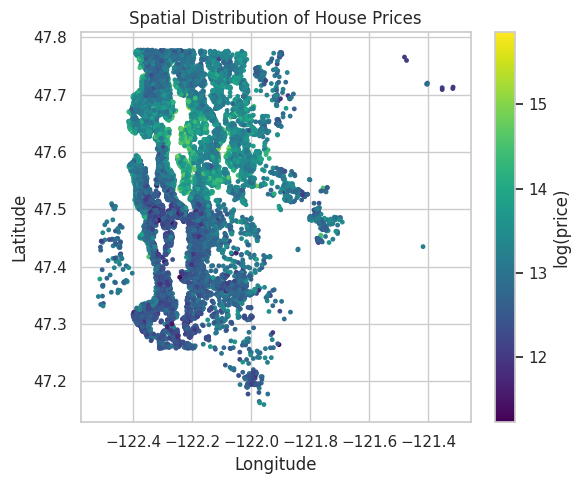

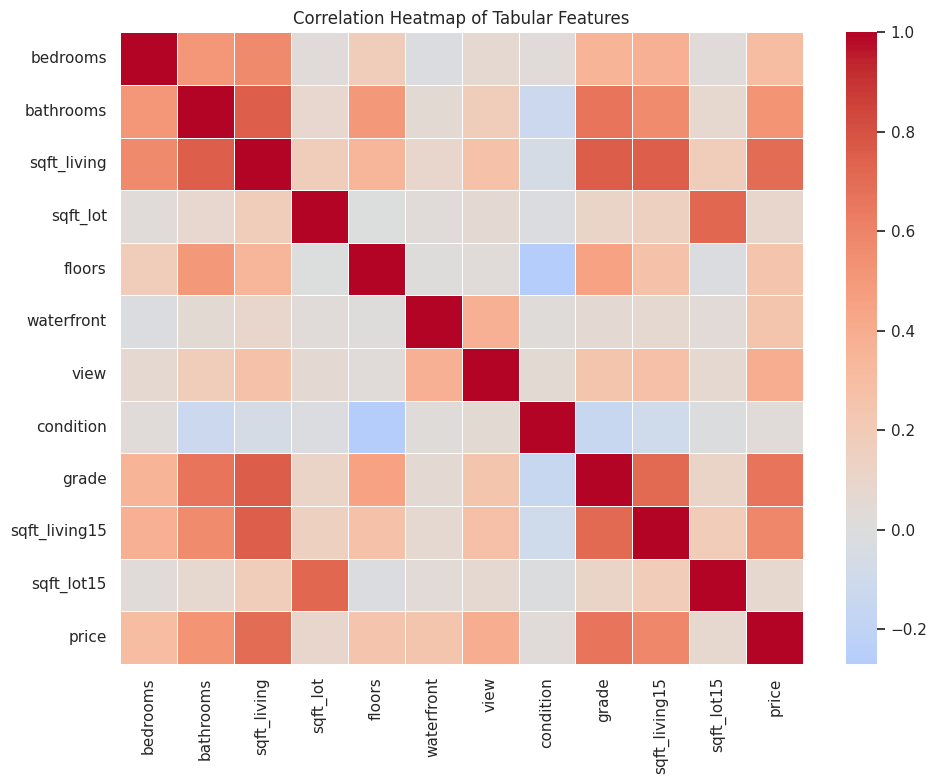

Summary statistics for price:
count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

Summary statistics for log(price):
count    16209.000000
mean        13.045201
std          0.523880
min         11.225257
25%         12.676079
50%         13.017005
75%         13.369225
max         15.856731
Name: log_price, dtype: float64


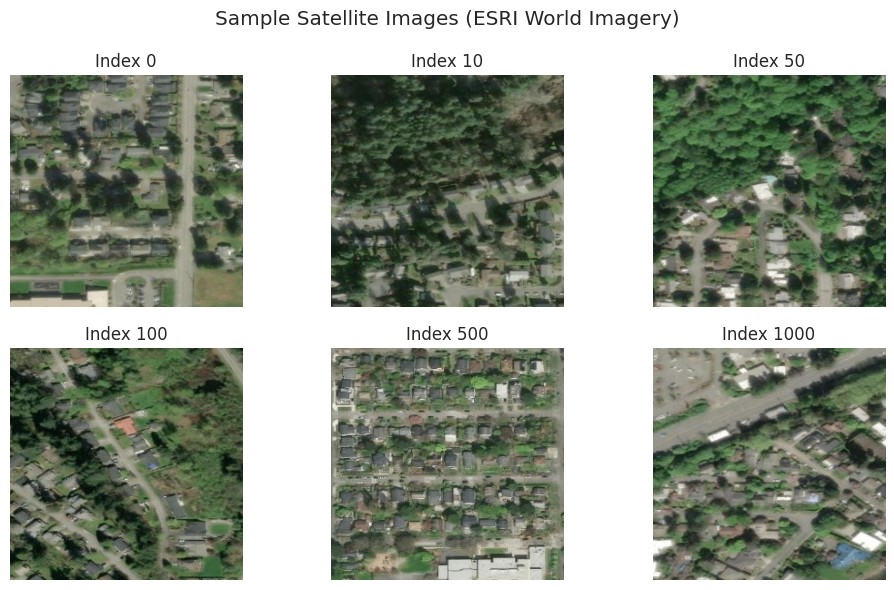

In [8]:
# ======================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ======================================================
# 1. RAW PRICE DISTRIBUTION
# ======================================================
plt.figure(figsize=(6, 4))
sns.histplot(train_df["price"], bins=50, kde=True)
plt.title("Distribution of House Prices (Raw)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ======================================================
# 2. LOG-TRANSFORMED PRICE DISTRIBUTION
# ======================================================
train_df["log_price"] = np.log1p(train_df["price"])

plt.figure(figsize=(6, 4))
sns.histplot(train_df["log_price"], bins=50, kde=True)
plt.title("Distribution of Log-Transformed House Prices")
plt.xlabel("log(price + 1)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ======================================================
# 3. PRICE vs IMPORTANT TABULAR FEATURES
# ======================================================
features_to_check = [
    "sqft_living",
    "bedrooms",
    "bathrooms",
    "grade",
    "view"
]

for feature in features_to_check:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(
        x=train_df[feature],
        y=train_df["log_price"],
        alpha=0.3
    )
    plt.title(f"log(price) vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("log(price)")
    plt.tight_layout()
    plt.show()

# ======================================================
# 4. SPATIAL (GEOGRAPHIC) PRICE DISTRIBUTION
# ======================================================
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=train_df["log_price"],
    cmap="viridis",
    s=6
)

plt.colorbar(scatter, label="log(price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of House Prices")
plt.tight_layout()
plt.show()

# ======================================================
# 5. CORRELATION HEATMAP 
# ======================================================
corr_features = TABULAR_FEATURES + ["price"]
corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Tabular Features")
plt.tight_layout()
plt.show()

# ======================================================
# BASIC SUMMARY STATISTICS 
# ======================================================
print("Summary statistics for price:")
print(train_df["price"].describe())

print("\nSummary statistics for log(price):")
print(train_df["log_price"].describe())
# ===============================
#  SAMPLE SATELLITE IMAGE INSPECTION
# ===============================
sample_indices = [0, 10, 50, 100, 500, 1000]

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, idx in zip(axes.flatten(), sample_indices):
    img_path = f"/kaggle/working/images/train/{idx}.png"
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Index {idx}")
    ax.axis("off")

plt.suptitle("Sample Satellite Images (ESRI World Imagery)")
plt.tight_layout()
plt.show()

In [ ]:
# =====================================================
# TRAINING ON BASELINE(TABULAR DATA)(Training1.py)
# =====================================================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# ======================================================
# PREPARE FEATURES & TARGET
# ======================================================
X = train_df[TABULAR_FEATURES]
y = np.log1p(train_df[TARGET_COL])

# ======================================================
# TRAIN / VALIDATION SPLIT
# ======================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ======================================================
# TABULAR BASELINE MODEL(XgBoost)
# ======================================================
tab_model = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

tab_model.fit(X_train, y_train)

# ======================================================
# PREDICTION
# ======================================================
val_preds_log = tab_model.predict(X_val)

# ======================================================
# METRICS 
# ======================================================
mse_log = mean_squared_error(y_val, val_preds_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_val, val_preds_log)

print(f"Tabular Model RMSE (log scale): {rmse_log:.4f}")
print(f"Tabular Model R² (log scale):   {r2_log:.4f}")

# ======================================================
# ORIGINAL PRICE SCALE
# ======================================================
val_preds_price = np.expm1(val_preds_log)
y_val_price = np.expm1(y_val)

mse_price = mean_squared_error(y_val_price, val_preds_price)
rmse_price = np.sqrt(mse_price)

print(f"Tabular Model RMSE (price scale): {rmse_price:.2f}")


Tabular Model RMSE (log scale): 0.2909
Tabular Model R² (log scale):   0.6933
Tabular Model RMSE (price scale): 187610.09


In [ ]:
# ======================================================
# STEP 5: CNN FEATURE EXTRACTION
# ======================================================

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

# ------------------------------------------------------
# DEVICE
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------
# LOAD PRETRAINED CNN (RESNET-18)
# ------------------------------------------------------
cnn = models.resnet18(pretrained=True)
cnn.fc = torch.nn.Identity()   # remove classifier
cnn = cnn.to(device)
cnn.eval()

# ------------------------------------------------------
# IMAGE TRANSFORMS (IMAGENET STANDARD)
# ------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ------------------------------------------------------
# EMBEDDING FUNCTION
# ------------------------------------------------------
def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = cnn(img)

    return emb.squeeze().cpu().numpy()

# ------------------------------------------------------
# EXTRACT TRAIN IMAGE EMBEDDINGS
# ------------------------------------------------------
TRAIN_IMG_DIR = "/kaggle/working/images/train"

train_image_embeddings = []

print("Extracting CNN embeddings...")

for idx in tqdm(range(len(train_df))):
    img_path = os.path.join(TRAIN_IMG_DIR, f"{idx}.png")
    emb = extract_embedding(img_path)
    train_image_embeddings.append(emb)

train_image_embeddings = np.vstack(train_image_embeddings)

print("Train image embeddings shape:", train_image_embeddings.shape)

# ------------------------------------------------------
# SAVE
# ------------------------------------------------------
np.save("/kaggle/working/train_image_embeddings.npy", train_image_embeddings)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting CNN embeddings...


100%|██████████| 16209/16209 [02:03<00:00, 130.84it/s]


Train image embeddings shape: (16209, 512)


In [ ]:
# =====================================================
# TRAINING ON TABULAR + VISUAL DATA(TABULAR DATA)(Training2.py)
# =====================================================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# ======================================================
# LOAD CNN IMAGE EMBEDDINGS
# ======================================================
image_embeddings = np.load("/kaggle/working/train_image_embeddings.npy")

print("Image embeddings shape:", image_embeddings.shape)

# ======================================================
# PREPARE TABULAR FEATURES & TARGET
# ======================================================
X_tab = train_df[TABULAR_FEATURES].values
y = np.log1p(train_df[TARGET_COL])

print("Tabular features shape:", X_tab.shape)
print("Target shape:", y.shape)

# ======================================================
# FUSE TABULAR + IMAGE FEATURES
# ======================================================
X_fused = np.hstack([X_tab, image_embeddings])

print("Fused feature matrix shape:", X_fused.shape)

# ======================================================
# TRAIN / VALIDATION SPLIT
# ======================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_fused,
    y,
    test_size=0.2,
    random_state=42
)

# ======================================================
# MULTIMODAL REGRESSION MODEL
# ======================================================
multi_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

multi_model.fit(X_train, y_train)

# ======================================================
# EVALUATION (LOG SCALE)
# ======================================================
val_preds_log = multi_model.predict(X_val)

mse_log = mean_squared_error(y_val, val_preds_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_val, val_preds_log)

print(f"Multimodal RMSE (log scale): {rmse_log:.4f}")
print(f"Multimodal R² (log scale):   {r2_log:.4f}")

# ======================================================
# EVALUATION ON ORIGINAL PRICE SCALE
# ======================================================
val_preds_price = np.expm1(val_preds_log)
y_val_price = np.expm1(y_val)

mse_price = mean_squared_error(y_val_price, val_preds_price)
rmse_price = np.sqrt(mse_price)

print(f"Multimodal RMSE (price scale): {rmse_price:.2f}")


Image embeddings shape: (16209, 512)
Tabular features shape: (16209, 11)
Target shape: (16209,)
Fused feature matrix shape: (16209, 523)
Multimodal RMSE (log scale): 0.2540
Multimodal R² (log scale):   0.7663
Multimodal RMSE (price scale): 169231.18


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


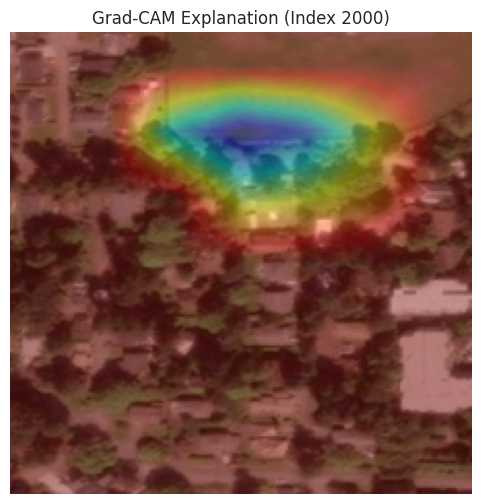

In [ ]:
# =====================================================
# GRADCAM_USAGE FOR EXPLAINABILITY
# =====================================================
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# ======================================================
# DEVICE SETUP
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ======================================================
# LOAD PRETRAINED RESNET 
# ======================================================
resnet = models.resnet18(pretrained=True)
resnet.eval()
resnet = resnet.to(device)

# ======================================================
# GRAD-CAM STORAGE
# ======================================================
feature_maps = []
gradients = []

# ======================================================
# HOOK FUNCTIONS
# ======================================================
def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# ======================================================
# REGISTER HOOK ON LAST CONV LAYER
# ======================================================
target_layer = resnet.layer4[-1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# ======================================================
# IMAGE TRANSFORM (IMAGENET STANDARD)
# ======================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ======================================================
# SELECT IMAGE INDEX TO EXPLAIN
# ======================================================
idx = 2000   # this index decides properties of which image is being shown
img_path = f"/kaggle/working/images/train/{idx}.png"

# ======================================================
# LOAD IMAGE
# ======================================================
original_img = Image.open(img_path).convert("RGB")
input_tensor = transform(original_img).unsqueeze(0).to(device)

# ======================================================
# FORWARD + BACKWARD PASS
# ======================================================
resnet.zero_grad()
output = resnet(input_tensor)

# Use mean activation as importance signal
loss = output.mean()
loss.backward()

# ======================================================
# BUILD GRAD-CAM HEATMAP
# ======================================================
grads = gradients[0]          # gradients w.r.t feature maps
acts = feature_maps[0]        # feature maps

# Global average pooling on gradients
weights = grads.mean(dim=(2, 3), keepdim=True)

# Weighted sum of feature maps
cam = (weights * acts).sum(dim=1).squeeze()

# Apply ReLU
cam = torch.relu(cam)

# Normalize CAM
cam = cam.detach().cpu().numpy()
cam = cv2.resize(cam, (224, 224))
cam = cam - cam.min()
cam = cam / cam.max()

# ======================================================
# OVERLAY HEATMAP ON IMAGE
# ======================================================
img_np = np.array(original_img.resize((224, 224)))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# ======================================================
# DISPLAY RESULT
# ======================================================
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Grad-CAM Explanation (Index {idx})")
plt.show()


In [ ]:
# =====================================================
# USING THE TRAINED MODEL TO PREDICT 
# =====================================================
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import os

# ======================================================
# LOAD TRAINED MULTIMODAL MODEL (ALREADY IN MEMORY)
# ======================================================
# Assumes `multi_model` from Step 6 exists

# ======================================================
# LOAD CNN MODEL (FOR TEST EMBEDDINGS)
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.eval()
resnet = resnet.to(device)

# ======================================================
# IMAGE TRANSFORM
# ======================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(img)
    return emb.squeeze().cpu().numpy()

# ======================================================
# EXTRACT TEST IMAGE EMBEDDINGS
# ======================================================
TEST_IMG_DIR = "/kaggle/working/images/test"
test_image_embeddings = []

print("Extracting CNN embeddings for TEST images...")

for idx in tqdm(range(len(test_df))):
    img_path = os.path.join(TEST_IMG_DIR, f"{idx}.png")
    emb = extract_embedding(img_path)
    test_image_embeddings.append(emb)

test_image_embeddings = np.vstack(test_image_embeddings)

# ======================================================
# PREPARE TABULAR TEST FEATURES
# ======================================================
X_tab_test = test_df[TABULAR_FEATURES].values

# ======================================================
# FUSE TABULAR + IMAGE FEATURES
# ======================================================
X_test_fused = np.hstack([X_tab_test, test_image_embeddings])

# ======================================================
# PREDICT (LOG SCALE → ORIGINAL SCALE)
# ======================================================
test_preds_log = multi_model.predict(X_test_fused)
test_preds_price = np.expm1(test_preds_log)

# ======================================================
# CREATE SUBMISSION CSV
# ======================================================
submission = test_df.copy()
submission["predicted_price"] = test_preds_price
submission["id"] = submission.id

submission_csv = submission[["id", "predicted_price"]]
submission_csv.to_csv("/kaggle/working/predictions.csv", index=False)

print("predictions.csv saved successfully.")


Extracting CNN embeddings for TEST images...


100%|██████████| 5404/5404 [00:40<00:00, 134.31it/s]


predictions.csv saved successfully.


In [35]:
import pandas as pd

preds = pd.read_csv("/kaggle/working/predictions.csv")
preds.head()


,id,predicted_price
0,2591820310,341816.44
1,7974200820,783393.80
2,7701450110,1339190.10
3,9522300010,1495160.60
4,9510861140,626520.60
